# Sample Run for final Dataset

# Import necessary packages

In [1]:
import os
os.chdir("../../../")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [3]:
import exoNet
import scanpy as sc
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

Using TensorFlow backend.


# Data Loading and Preprocessing

In [4]:
data_name = "final"

In [5]:
data = np.load(f"./Data/{data_name}/sequences.npy", allow_pickle=True)
data = data[:, :, :4]
data.shape

(200221, 50, 4)

In [6]:
labels = np.load(f"./Data/{data_name}/labels.npy", allow_pickle=True)
labels = np.reshape(labels, (-1,))
labels.shape

(200221,)

# Model Instatiation

In [7]:
network = exoNet.models.ExoCNN(seq_len=data.shape[1],
                               n_channels=data.shape[2],
                               n_classes=2,
                               padding="same",
                               use_batchnorm=True,
                               lr=0.0001,
                               model_path=f"./models/ExoCNN/{data_name}",
                               class_weight={0: 0.2, 1:0.8},
                               dropout_rate=0.4,
                               )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            (None, 50, 4)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 32)            1280      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 32)            128       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 50, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 64)            20480     
_________________________________________________________________
batch_normalization_2

In [7]:
network.restore_model_weights()

In [8]:
network.train(data,
              labels, 
              le={"NO": 0, "YES": 1},
              n_epochs=500,
              batch_size=32,
              early_stopping_kwargs={"patience": 5, "monitor": "val_loss"},
              lr_reducer_kwargs={"patience": 3, "monitor": "val_loss"},
              save=True,
              verbose=2,
              )

Instructions for updating:
Use tf.cast instead.
Train on 160176 samples, validate on 40045 samples
Epoch 1/500
 - 138s - loss: 0.1388 - acc: 0.7749 - sensitivity: 0.8583 - specificity: 0.7590 - val_loss: 0.4407 - val_acc: 0.7648 - val_sensitivity: 0.9117 - val_specificity: 0.7277
Epoch 2/500
 - 129s - loss: 0.1246 - acc: 0.7990 - sensitivity: 0.8944 - specificity: 0.7803 - val_loss: 0.3644 - val_acc: 0.8228 - val_sensitivity: 0.8726 - val_specificity: 0.8105
Epoch 3/500
 - 129s - loss: 0.1164 - acc: 0.8097 - sensitivity: 0.9068 - specificity: 0.7904 - val_loss: 0.3438 - val_acc: 0.8304 - val_sensitivity: 0.8829 - val_specificity: 0.8172
Epoch 4/500
 - 129s - loss: 0.1093 - acc: 0.8232 - sensitivity: 0.9150 - specificity: 0.8046 - val_loss: 0.3447 - val_acc: 0.8338 - val_sensitivity: 0.8918 - val_specificity: 0.8194
Epoch 5/500
 - 129s - loss: 0.1032 - acc: 0.8334 - sensitivity: 0.9236 - specificity: 0.8148 - val_loss: 0.3374 - val_acc: 0.8299 - val_sensitivity: 0.9056 - val_specificity

In [9]:
predicted_labels = network.model.predict(data)
predicted_labels.shape

(200221, 2)

In [40]:
network.model_path

'./models/ExoCNN/final'

In [10]:
predicted_labels[0]

array([9.9999034e-01, 9.6076947e-06], dtype=float32)

In [12]:
identifiers = pd.read_csv(f"./Data/{data_name}/{data_name}.design.mat.subset.shortened.csv")['id']
identifiers.head()

0     chr13_80888929_80888951_+_ic
1         chr12_674559_674597_-_ic
2     chr18_50353832_50353853_-_ic
3    chr2_148657600_148657623_+_ic
4    chr2_191537005_191537027_-_ic
Name: id, dtype: object

In [15]:
sequences = pd.read_csv(f"./Data/{data_name}/{data_name}.design.mat.subset.shortened.csv")['seq']
sequences.head()

0                    UUUUGAUCAAACGUAGAACCAAU
1    GUGCUAGGUCCCCAGAUCAAGUCAGAUGCCAACGAGAUU
2                     ACUUCAAUCUGGGAUUUUUAUA
3                   AACUCUCCAUCAUAACAUCAAGAA
4                    AUUUCCAUGCCAGGAUUUUUCCC
Name: seq, dtype: object

In [16]:
results = pd.DataFrame({'id': identifiers, 'seq': sequences, 'no': predicted_labels[:, 0], 'yes': predicted_labels[:, 1]})
results.head()

,id,seq,no,yes
0,chr13_80888929_80888951_+_ic,UUUUGAUCAAACGUAGAACCAAU,0.999990,0.000010
1,chr12_674559_674597_-_ic,GUGCUAGGUCCCCAGAUCAAGUCAGAUGCCAACGAGAUU,0.999995,0.000004
2,chr18_50353832_50353853_-_ic,ACUUCAAUCUGGGAUUUUUAUA,0.770152,0.229848
3,chr2_148657600_148657623_+_ic,AACUCUCCAUCAUAACAUCAAGAA,0.983129,0.016871
4,chr2_191537005_191537027_-_ic,AUUUCCAUGCCAGGAUUUUUCCC,0.244401,0.755599


In [29]:
path_to_save = "/media/pgdrive/sharif/exosomians/predictions/ExoCNN/"

In [35]:
results.to_csv(os.path.join(path_to_save, "ExoCNN.final.probabilities.csv"))

In [43]:
ev_extreme_results = results[results['id'].str.contains('ev')]
ev_extreme_results = ev_extreme_results[ev_extreme_results['yes'] >= ev_extreme_results['yes'].quantile(.90)]
ev_extreme_results.shape

(4023, 4)

In [44]:
ic_extreme_results = results[results['id'].str.contains('ic')]
ic_extreme_results = ic_extreme_results[ic_extreme_results['no'] >= ic_extreme_results['no'].quantile(.90)]
ic_extreme_results.shape

(18730, 4)

In [46]:
ev_extreme_results.to_csv(os.path.join(path_to_save, "ExoCNN.ev.extreme.90.probabilities.csv"))

In [45]:
ic_extreme_results.to_csv(os.path.join(path_to_save, "ExoCNN.ic.extreme.90.probabilities.csv"))

In [16]:
import innvestigate
import innvestigate.utils as iutils

In [17]:
model_wo_sm = iutils.keras.graph.model_wo_softmax(network.model)

In [18]:
analyzer = innvestigate.create_analyzer("deep_taylor.bounded",        # analysis method identifier
                                        model_wo_sm, # model without softmax output
                                        low=0.0, high=1.0)

In [31]:
heatmaps = analyzer.analyze(data[ic_extreme_results.index, :])
heatmaps.shape

(4100, 500, 4)

In [32]:
labels_enc, _ = exoNet.utils.label_encoder(labels, {"NO": 0, "YES": 1})

In [33]:
import keras

In [34]:
labels_one = keras.utils.to_categorical(labels_enc, num_classes=2)

In [ ]:
network.model.evaluate(data, labels_one)

21216/82032 [======>.......................] - ETA: 18s

In [28]:
heatmaps.shape

(4105, 500, 4)

In [29]:
np.save(file="/media/pgdrive/sharif/exosomians/data/bams/model1.ev.extremes.heatmaps.pkl", arr=heatmaps)

In [35]:
np.save(file="/media/pgdrive/sharif/exosomians/data/bams/model1.ic.extremes.heatmaps.pkl", arr=heatmaps)

In [19]:
heatmaps = np.reshape(heatmaps, (-1, 500*4))
heatmaps.shape

(4101, 2000)

In [22]:
np.savetxt(X=heatmaps, fname="./model1.ev.extremes.heatmaps.csv", delimiter=',')

In [13]:
import seaborn as sns; sns.set()

In [21]:
sequences = pd.read_csv(f"./Data/{data_name}/{data_name}.design.mat.csv")['seq']
sequences.head()

0                             UGGGAUUGGGGAUUGGGAUUGGGA
1                               GGUUGGGAUUGGGGAUUGGGAU
2                                 AUUGGGAUUGGGGAUUGGGG
3    GAUUGGGAUUGGGAUUGGGAUUGGGAUUGGGAUUGGGGAUUGGGAU...
4                        GGCCCAGACUGGACUCCUCUUGACACGAG
Name: seq, dtype: object

UGGGAUUGGGGAUUGGGAUUGGGA


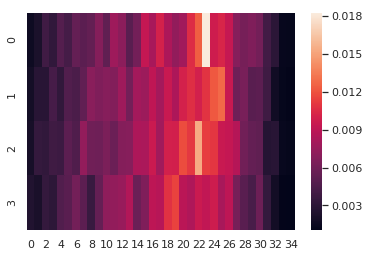

In [22]:
print(sequences[0])
g = sns.heatmap(heatmaps[0, :35].T)

In [26]:
network.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            (None, 500, 4)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 32)           1280      
_________________________________________________________________
batch_normalization_1 (Batch (None, 500, 32)           128       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 500, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 32)           10240     
_________________________________________________________________
batch_normalization_2 (Batch (None, 500, 32)           128       
_________________________________________________________________
re_lu_2 (ReLU)               (None, 500, 32)           0         
__________